<a href="https://colab.research.google.com/github/rezwanh001/Fashion-MNIST-with-CNN/blob/master/Fashion_MNIST_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**The Fashion MNIST dataset is meant to be a (slightly more challenging) drop-in replacement for the (less challenging) MNIST dataset.**



Similar to the MNIST digit dataset, the Fashion MNIST dataset includes:

1.   60,000 training examples
2.   10,000 testing examples
3.   10 classes
4.    28×28 grayscale/single channel images


The ten fashion class labels include:

1.  T-shirt/top
2.  Trouser/pants
3.  Pullover shirt
4.  Dress
5.  Coat
6.  Sandal
7.  Shirt
8.  Sneaker
9.  Bag
10. Ankle boot

*References*

[1. Fashion MNIST with Keras and Deep Learning](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/)

[2. fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

[3. http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/)

### (1) Defining a simple Convolutional Neural Network (CNN)

In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

class CNN:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape
    # to be "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (height, width, depth)
      chanDim = 1
      
    # 1st CONV -> RELU -> CONV -> RELU -> POOL layer set
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # 2nd CONV -> RELU -> CONV -> RELU -> POOL layer set
    model.add(Conv2D(64, (3,3), padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # 1st (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    # return the constructed network architecture
    return model

Using TensorFlow backend.




*   Pooling layers help to progressively reduce the spatial dimensions of the input volume.
*  Batch normalization, as the name suggests, seeks to normalize the activations of a given input volume before passing it into the next layer. It has been shown to be effective at reducing the number of epochs required to train a CNN at the expense of an increase in per-epoch time.
*  Dropout is a form of regularization that aims to prevent overfitting. Random connections are dropped to ensure that no single node in the network is responsible for activating when presented with a given pattern.




### (2) Download the Fashion MNIST dataset

In [0]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### (3) Implementing the Fashion MNIST training script with Keras

Now that CNN is implemented we can move on to the driver script which:

* Loads the Fashion MNIST dataset.
* Trains CNN on Fashion MNIST + generates a training history plot.
* Evaluates the resulting model and outputs a classification report.
* Creates a montage visualization allowing us to see our results visually.

In [0]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg") #The "Agg"  backend is used for Matplotlib so that we can save our training plot to disk.

from sklearn.metrics import classification_report
from keras.optimizers import SGD, Adam, Adadelta
from keras.utils import np_utils
from imutils import build_montages
import numpy as np
import cv2

# Initialize EPOCHS, LR_RATE, BATCH_SIZE
NUM_EPOCHS = 50
INIT_LR = 1e-2
BATCH_SIZE = 32

## if we are using "channels_first" ordering, then reshape the design
## matrix such that the matrix is:
## num_sanples x depth x rows x cols

if K.image_data_format() == 'channels_first':
  X_train = X_train.reshape((X_train.shape[0], 1 , 28, 28))
  X_test = X_test.reshape((X_test.shape[0], 1 , 28, 28))  
else:
  ## Otherwise use "channels_last"
  X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
  X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)) 
  

  
## Preprocess dataset + prepare data

# Scale data to the frame of [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

#one=hot encode the training and test labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# initialize the labels names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [6]:


# Initialize the optimizer and model
print("Compiling Model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = CNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, 
                                   metrics=['accuracy'])

# Train The model
print("Training model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Compiling Model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Training model...
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 29s 490us/step - loss: 0.4818 - acc: 0.8316 - val_loss: 0.3251 - val_acc: 0.8868
Epoch 2/50
60000/60000 [==============================] - 27s 455us/step - loss: 0.3088 - acc: 0.8901 - val_loss: 0.2666 - val_acc: 0.9061
Epoch 3/50
60000/60000 [==============================] - 27s 454us/step - loss: 0.2672 - acc: 0.9023 - val_loss: 0.2886 - val_acc: 0.8940
Epoch 4/50
60000/60000 [==============================] - 27s 454us/step - loss: 0.2413 - acc: 0.9129 - val_loss: 0.2544 - val_acc: 0.9068
Epoch 5/50
60000/60000 [==============================] - 27s 454us/step - loss: 0.2205 - acc: 0.9197 - val_loss: 0.2148 -

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
### Save model
###==========================================
from keras.models import load_model 
model.save('/content/gdrive/My Drive/Fashion_MNIST/fashion_mnist_cnn_model.h5') # creates a HDF5 file 'my_model.h5' 

# Final evaluation of the model
scores = model.evaluate(X_train, y_train, verbose=1)
print("Train Score: %.2f%%" % (scores[0]*100))
print("Train Accuracy: %.2f%%" % (scores[1]*100))

############## Final evaluation of the model For Test Set
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))


60000/60000 [==============================] - 7s 122us/step
Train Score: 2.89%
Train Accuracy: 99.25%
10000/10000 [==============================] - 1s 121us/step
Test Score: 18.99%
Test Accuracy: 94.31%


In [10]:
from keras.models import load_model 
#### Load Save nodel
# returns a compiled model 
# identical to the previous one 
mmodel = load_model('/content/gdrive/My Drive/Fashion_MNIST/fashion_mnist_cnn_model.h5')
scores = mmodel.evaluate(X_train, y_train, verbose=1)
print("Train Score Again: %.2f%%" % (scores[0]*100))
print("Train Accuracy Again: %.2f%%" % (scores[1]*100))

############## For Test Set from loading models
score = mmodel.evaluate(X_test, y_test, verbose=1)
print("Test Score Again: %.2f%%" % (score[0]*100))
print("Test Accuracy Again: %.2f%%" % (score[1]*100))

60000/60000 [==============================] - 8s 139us/step
Train Score Again: 2.89%
Train Accuracy Again: 99.25%
10000/10000 [==============================] - 1s 133us/step
Test Score Again: 18.99%
Test Accuracy Again: 94.31%


60000/60000 [==============================] - 9s 144us/step
* Train Score : 2.89%
* Train Accuracy : 99.25%

10000/10000 [==============================] - 1s 137us/step
* Test Score : 18.99%
* Test Accuracy : 94.31%

**Epochs = 50 **

### Predict on the test set(X_test)

In [11]:
# make predictions
preds = mmodel.predict(X_test)

# show the nicely formatted classification report
print("Evaluating network...")
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1),
     target_names=labelNames))



Evaluating network...
              precision    recall  f1-score   support

         top       0.90      0.90      0.90      1000
     trouser       1.00      0.99      0.99      1000
    pullover       0.93      0.93      0.93      1000
       dress       0.95      0.94      0.94      1000
        coat       0.90      0.93      0.91      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.82      0.82      0.82      1000
     sneaker       0.97      0.99      0.98      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.97      0.98      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [12]:
### List all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


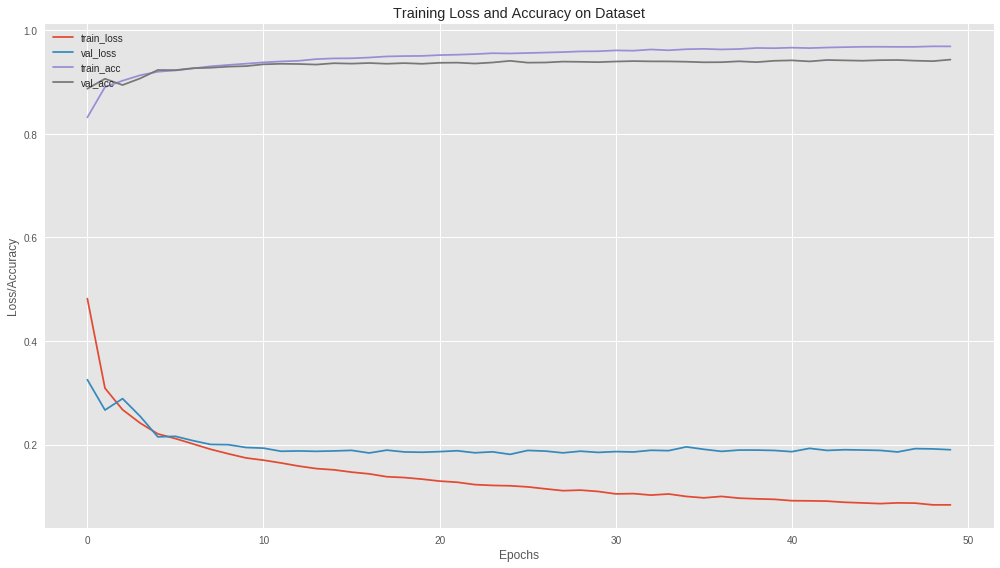

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

#plot the training loss and accuray
plt.style.use("ggplot")
plt.figure(figsize=(14,8))
plt.plot(np.arange(0, NUM_EPOCHS), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_acc'], label='val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# # plt.savefig("plot_perf.png")
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Fashion_MNIST/plot_loss_acc.png", dpi = 50)
plt.show()

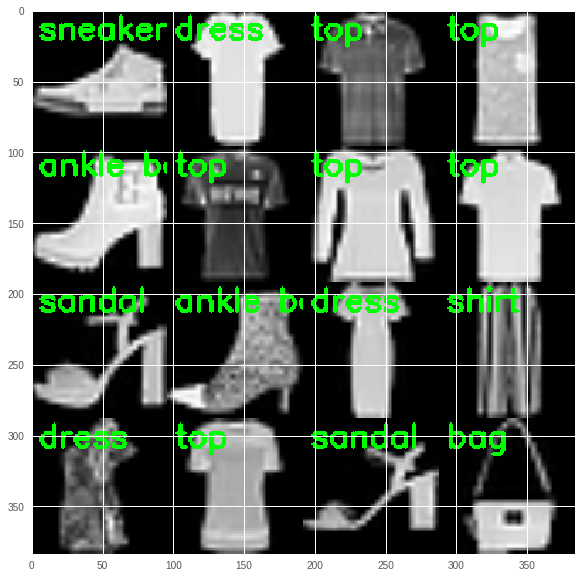

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# initialize our list of output images
images = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = mmodel.predict(X_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (X_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (X_test[i] * 255).astype("uint8")

	# initialize the text label color as green (correct)
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		(0, 255, 0), 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# show the output montage
# cv2.imshow("Fashion MNIST", montage)
# cv2.waitKey(0)
plt.imshow(montage, cmap='gray')
plt.show()